# Anomaly Detection
This is an attempt to classify the scans into all the 4 classes.
Since the data distro is kind of skewed (we have nearly $10K$ images of normal which is equal to the total number of scans of all the other classes combined), so we'll treat the *COVID*, *Viral Pneumonia* and *Lung Opacity* as an anomaly. This will be the stage one of the pipeline which will be followed by a classification of the anomalous images into the respective 3 classes.

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import h5py

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, MaxPooling2D, Add
from keras.callbacks import ModelCheckpoint

import os
import shutil

print("Imports Complete")

Imports Complete


## Loading the data

In [2]:
#shutil.rmtree("/tmp/anomaly")

In [3]:
!mkdir /tmp/anomaly

In [4]:
import glob
import shutil

def f2f(scr, dst='/tmp/anomaly'):
    for jf in glob.iglob(os.path.join(scr,"*.png")):
        shutil.copy(jf, dst)

In [5]:
"""

f2f(di+"COVID" )
f2f(di+'Lung_Opacity')
f2f(di+"Viral Pneumonia")
"""

'\n\nf2f(di+"COVID" )\nf2f(di+\'Lung_Opacity\')\nf2f(di+"Viral Pneumonia")\n'

In [6]:
!mkdir /tmp/normal

In [7]:
di = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/"
f2f(di+"Normal", "/tmp/normal")

Next we'll create a `dataset` of all the normal samples to train the *anomaly detection system*.

In [8]:
encotds = tf.keras.preprocessing.image_dataset_from_directory(
    "/tmp/normal", labels = None, color_mode = "rgb", batch_size = 32, 
    image_size = (224, 224), shuffle = True, seed = 42, 
    validation_split = 0.1, subset = "training", interpolation = "bicubic")

encovds = tf.keras.preprocessing.image_dataset_from_directory(
    "/tmp/normal", labels = None, color_mode = "rgb", batch_size = 32, 
    image_size = (224, 224), shuffle = True, seed = 42, 
    validation_split = 0.1, subset = "validation", interpolation = "bicubic")


Found 10192 files belonging to 1 classes.
Using 9173 files for training.


2022-02-22 19:10:51.304280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 19:10:51.400611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 19:10:51.401410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 19:10:51.406546: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 10192 files belonging to 1 classes.
Using 1019 files for validation.


Next, the dataset of all the anomalous samples.

In [9]:
"""
anoTds = tf.keras.preprocessing.image_dataset_from_directory(
    "/tmp/anomaly", labels = None, color_mode = "rgb", batch_size = 32, 
    image_size = (224, 224), shuffle = True, seed = 42, 
    validation_split = 0.1, subset = "training", interpolation = "bicubic")

anoVds = tf.keras.preprocessing.image_dataset_from_directory(
    "/tmp/anomaly", labels = None, color_mode = "rgb", batch_size = 32, 
    image_size = (224, 224), shuffle = True, seed = 42, 
    validation_split = 0.1, subset = "validation", interpolation = "bicubic")
"""

'\nanoTds = tf.keras.preprocessing.image_dataset_from_directory(\n    "/tmp/anomaly", labels = None, color_mode = "rgb", batch_size = 32, \n    image_size = (224, 224), shuffle = True, seed = 42, \n    validation_split = 0.1, subset = "training", interpolation = "bicubic")\n\nanoVds = tf.keras.preprocessing.image_dataset_from_directory(\n    "/tmp/anomaly", labels = None, color_mode = "rgb", batch_size = 32, \n    image_size = (224, 224), shuffle = True, seed = 42, \n    validation_split = 0.1, subset = "validation", interpolation = "bicubic")\n'

# The Model

In [10]:
def identity_block(X, f, filters, training=True):
    
    f1, f2, f3 = filters
    X_skip = X
    
    X = Conv2D(filters=f1, kernel_size=1, padding='valid')(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = tf.keras.activations.relu(X)
    
    X = Conv2D(filters=f2, kernel_size=f, padding='same')(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = tf.keras.activations.relu(X)
    
    X = Conv2D(filters=f3, kernel_size=1, padding='valid')(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    
    X = tf.keras.layers.Add()([X_skip, X])
    X = tf.keras.activations.relu(X)
    
    return X

In [11]:
def conv_block(X, f, filters, s=2, training=True):
    
    f1, f2, f3 = filters
    X_skip = X
    
    X = Conv2D(filters = f1, kernel_size = 1, strides = (s, s), padding='valid')(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = tf.keras.activations.relu(X)
    
    X = Conv2D(filters = f2, kernel_size = f, strides = (1, 1), padding='same')(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = tf.keras.activations.relu(X) 
    
    X = Conv2D(filters = f3, kernel_size = 1, strides = (1, 1), padding='valid')(X)
    X = BatchNormalization()(X, training = training)
    
    X_skip = Conv2D(filters = f3, kernel_size = 1, strides=(s,s), padding='valid')(X_skip)
    X_skip = BatchNormalization()(X_skip, training = training)
    
    X = Add()([X, X_skip])
    X = tf.keras.activations.relu(X)
    
    return X

In [12]:
def Trans_conv_block(X, f, filters, s=2, training=True):
    
    f1, f2, f3 = filters
    X_skip = X
    
    X = Conv2DTranspose(filters = f1, kernel_size = 1, strides = (s, s), padding='valid')(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = tf.keras.activations.relu(X)
    
    X = Conv2DTranspose(filters = f2, kernel_size = f, strides = (1, 1), padding='same')(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = tf.keras.activations.relu(X) 
    
    X = Conv2DTranspose(filters = f3, kernel_size = 1, strides = (1, 1), padding='same')(X)
    X = BatchNormalization()(X, training = training)
    
    X_skip = Conv2DTranspose(filters = f3, kernel_size = 1, strides=(s,s), padding='valid')(X_skip)
    X_skip = BatchNormalization()(X_skip, training = training)
    
    X = Add()([X, X_skip])
    X = tf.keras.activations.relu(X)
    
    return X

In [13]:
def enco(input_shape=(224,224,3)):
    
    X_inp = tf.keras.Input(shape=input_shape)
    
    X = Conv2D(64, (3,3), strides = (2,2))(X_inp)
    X = BatchNormalization(axis = 3)(X)
    X = tf.keras.activations.relu(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    X = conv_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    X = conv_block(X, 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    
    model = tf.keras.Model(inputs=X_inp,outputs=X)
    
    return model

In [14]:
mod = enco()
print(mod.output.shape)
mod.summary()

(None, 28, 28, 512)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, 111, 111, 64) 0           batch_normalization[0][0]        
__________________________________________________________________________

In [15]:
def deco(input_shape=(28,28,512)):
    
    X_inp = tf.keras.Input(shape=input_shape)
    
    X = Trans_conv_block(X_inp, 3, [256, 256, 128], s=2, training=True)
    X = identity_block(X, 3, [256, 128, 128])
    X = identity_block(X, 3, [256, 128, 128])
    
    X = Trans_conv_block(X, 3, [128, 64, 64], s=1, training=True)
    X = identity_block(X, 3, [128, 64, 64])
    X = identity_block(X, 3, [128, 64, 64])
    
    #X = Conv2DTranspose(64, (7,7), strides = (2,2), padding='valid')(X)
    X = Trans_conv_block(X, 3, [64, 32, 32], s=2, training=True)
    X = identity_block(X, 3, [64, 32, 32])
    X = identity_block(X, 3, [64, 32, 32])
    
    X = Trans_conv_block(X, 11, [64, 32, 32], s=2, training=True)
    X = Conv2D(filters=3 , kernel_size = 1, strides = 1, padding='valid')(X)
    
    model = tf.keras.Model(inputs=X_inp,outputs=X)
    
    return model   

In [16]:
mod = deco()
print(mod.output.shape)
mod.summary()

(None, 224, 224, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 512) 0                                            
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 56, 56, 256)  131328      input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 56, 56, 256)  1024        conv2d_transpose[0][0]           
__________________________________________________________________________________________________
tf.nn.relu_19 (TFOpLambda)      (None, 56, 56, 256)  0           batch_normalization_21[0][0]     
________________________________________________________________________

In [17]:
class Autoencoder(tf.keras.Model):
    
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = enco(input_shape=(224,224,3))
        self.decoder = deco(input_shape=(28,28,512)) 
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [18]:
autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss = 'MeanSquaredError')

In [19]:
tds = encotds.map(lambda x : (x,x))
vds = encovds.map(lambda x : (x,x))

In [20]:
filepath = "Checkpoint/cp.ckpt"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


In [21]:
history = autoencoder.fit(tds,
                epochs=150,
                shuffle=True,
                callbacks=[checkpoint],
                validation_data=vds)

2022-02-22 19:10:57.385928: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-02-22 19:11:03.660435: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


287/287 [==============================] - 147s 454ms/step - loss: 19382.1543 - val_loss: 17371.5215

Epoch 00001: val_loss improved from inf to 17371.52148, saving model to Checkpoint/cp.ckpt


2022-02-22 19:13:37.854507: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/150
287/287 [==============================] - 125s 434ms/step - loss: 13753.5361 - val_loss: 10255.3574

Epoch 00002: val_loss improved from 17371.52148 to 10255.35742, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/150
287/287 [==============================] - 125s 433ms/step - loss: 6589.3359 - val_loss: 3823.5215

Epoch 00003: val_loss improved from 10255.35742 to 3823.52148, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/150
287/287 [==============================] - 125s 433ms/step - loss: 2041.1158 - val_loss: 914.6367

Epoch 00004: val_loss improved from 3823.52148 to 914.63666, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/150
287/287 [==============================] - 126s 434ms/step - loss: 409.1430 - val_loss: 175.9470

Epoch 00005: val_loss improved from 914.63666 to 175.94704, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/150
287/287 [==============================] - 126s 434ms/step - loss: 93.3612 - val_loss: 68.6626

Epoch 00006: val_loss improved from 175.94704 to 68.66264, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/150
287/287 [==============================] - 125s 434ms/step - loss: 57.9504 - val_loss: 50.5541

Epoch 00007: val_loss improved from 68.66264 to 50.55405, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/150
287/287 [==============================] - 126s 435ms/step - loss: 50.2373 - val_loss: 46.1107

Epoch 00008: val_loss improved from 50.55405 to 46.11071, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/150
287/287 [==============================] - 126s 435ms/step - loss: 46.4704 - val_loss: 47.1151

Epoch 00009: val_loss did not improve from 46.11071
Epoch 10/150
287/287 [==============================] - 125s 433ms/step - loss: 45.8654 - val_loss: 51.6090

Epoch 00010: val_loss did not improve from 46.11071
Epoch 11/150
287/287 [==============================] - 126s 435ms/step - loss: 42.4052 - val_loss: 38.7534

Epoch 00011: val_loss improved from 46.11071 to 38.75341, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/150
287/287 [==============================] - 126s 436ms/step - loss: 43.5259 - val_loss: 45.0244

Epoch 00012: val_loss did not improve from 38.75341
Epoch 13/150
287/287 [==============================] - 126s 435ms/step - loss: 42.2725 - val_loss: 47.3058

Epoch 00013: val_loss did not improve from 38.75341
Epoch 14/150
287/287 [==============================] - 126s 435ms/step - loss: 38.4785 - val_loss: 41.0804

Epoch 00014: val_loss did not improve from 38.75341
Epoch 15/150
287/287 [==============================] - 125s 434ms/step - loss: 36.3464 - val_loss: 34.0389

Epoch 00015: val_loss improved from 38.75341 to 34.03891, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 16/150
287/287 [==============================] - 126s 435ms/step - loss: 37.8327 - val_loss: 40.8041

Epoch 00016: val_loss did not improve from 34.03891
Epoch 17/150
287/287 [==============================] - 125s 435ms/step - loss: 34.1511 - val_loss: 29.3780

Epoch 00017: val_loss improved from 34.03891 to 29.37803, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 18/150
287/287 [==============================] - 126s 435ms/step - loss: 32.9623 - val_loss: 28.7569

Epoch 00018: val_loss improved from 29.37803 to 28.75690, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 19/150
287/287 [==============================] - 126s 436ms/step - loss: 33.5565 - val_loss: 33.7567

Epoch 00019: val_loss did not improve from 28.75690
Epoch 20/150
287/287 [==============================] - 126s 435ms/step - loss: 31.4749 - val_loss: 39.2412

Epoch 00020: val_loss did not improve from 28.75690
Epoch 21/150
287/287 [==============================] - 125s 434ms/step - loss: 31.8831 - val_loss: 30.3549

Epoch 00021: val_loss did not improve from 28.75690
Epoch 22/150
287/287 [==============================] - 126s 435ms/step - loss: 29.6141 - val_loss: 28.1791

Epoch 00022: val_loss improved from 28.75690 to 28.17914, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 23/150
287/287 [==============================] - 126s 435ms/step - loss: 31.8277 - val_loss: 26.1459

Epoch 00023: val_loss improved from 28.17914 to 26.14591, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 24/150
287/287 [==============================] - 126s 435ms/step - loss: 26.7329 - val_loss: 24.9974

Epoch 00024: val_loss improved from 26.14591 to 24.99744, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 25/150
287/287 [==============================] - 126s 436ms/step - loss: 29.0805 - val_loss: 34.6858

Epoch 00025: val_loss did not improve from 24.99744
Epoch 26/150
287/287 [==============================] - 126s 436ms/step - loss: 27.2881 - val_loss: 30.9247

Epoch 00026: val_loss did not improve from 24.99744
Epoch 27/150
287/287 [==============================] - 125s 434ms/step - loss: 27.8448 - val_loss: 31.2354

Epoch 00027: val_loss did not improve from 24.99744
Epoch 28/150
287/287 [==============================] - 126s 435ms/step - loss: 24.3473 - val_loss: 23.9346

Epoch 00028: val_loss improved from 24.99744 to 23.93460, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 29/150
287/287 [==============================] - 126s 436ms/step - loss: 22.9176 - val_loss: 22.2133

Epoch 00029: val_loss improved from 23.93460 to 22.21333, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 30/150
287/287 [==============================] - 126s 436ms/step - loss: 20.7087 - val_loss: 21.6432

Epoch 00030: val_loss improved from 22.21333 to 21.64321, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 31/150
287/287 [==============================] - 126s 436ms/step - loss: 21.5801 - val_loss: 20.4791

Epoch 00031: val_loss improved from 21.64321 to 20.47906, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 32/150
287/287 [==============================] - 126s 436ms/step - loss: 21.2440 - val_loss: 19.5716

Epoch 00032: val_loss improved from 20.47906 to 19.57161, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 33/150
287/287 [==============================] - 126s 435ms/step - loss: 21.0190 - val_loss: 26.1874

Epoch 00033: val_loss did not improve from 19.57161
Epoch 34/150
287/287 [==============================] - 126s 436ms/step - loss: 22.0629 - val_loss: 24.6805

Epoch 00034: val_loss did not improve from 19.57161
Epoch 35/150
287/287 [==============================] - 125s 435ms/step - loss: 19.5454 - val_loss: 22.8337

Epoch 00035: val_loss did not improve from 19.57161
Epoch 36/150
287/287 [==============================] - 125s 435ms/step - loss: 17.5979 - val_loss: 24.4362

Epoch 00036: val_loss did not improve from 19.57161
Epoch 37/150
287/287 [==============================] - 126s 437ms/step - loss: 17.9410 - val_loss: 21.6164

Epoch 00037: val_loss did not improve from 19.57161
Epoch 38/150
287/287 [==============================] - 126s 437ms/step - loss: 19.6296 - val_loss: 17.5626

Epoch 00038: val_loss improved from 19.57161 to 17.56260, saving model to Checkpoint/c

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 39/150
287/287 [==============================] - 126s 436ms/step - loss: 19.7045 - val_loss: 16.9750

Epoch 00039: val_loss improved from 17.56260 to 16.97498, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 40/150
287/287 [==============================] - 126s 437ms/step - loss: 17.7141 - val_loss: 18.5296

Epoch 00040: val_loss did not improve from 16.97498
Epoch 41/150
287/287 [==============================] - 126s 435ms/step - loss: 18.7231 - val_loss: 21.7257

Epoch 00041: val_loss did not improve from 16.97498
Epoch 42/150
287/287 [==============================] - 126s 435ms/step - loss: 16.8666 - val_loss: 18.3297

Epoch 00042: val_loss did not improve from 16.97498
Epoch 43/150
287/287 [==============================] - 125s 434ms/step - loss: 15.8146 - val_loss: 16.2395

Epoch 00043: val_loss improved from 16.97498 to 16.23948, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 44/150
287/287 [==============================] - 126s 435ms/step - loss: 15.2942 - val_loss: 21.7095

Epoch 00044: val_loss did not improve from 16.23948
Epoch 45/150
287/287 [==============================] - 126s 436ms/step - loss: 15.9106 - val_loss: 15.7970

Epoch 00045: val_loss improved from 16.23948 to 15.79700, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 46/150
287/287 [==============================] - 125s 435ms/step - loss: 15.3143 - val_loss: 16.3930

Epoch 00046: val_loss did not improve from 15.79700
Epoch 47/150
287/287 [==============================] - 126s 437ms/step - loss: 14.6418 - val_loss: 16.6731

Epoch 00047: val_loss did not improve from 15.79700
Epoch 48/150
287/287 [==============================] - 125s 435ms/step - loss: 15.2361 - val_loss: 17.2985

Epoch 00048: val_loss did not improve from 15.79700
Epoch 49/150
287/287 [==============================] - 126s 437ms/step - loss: 14.8107 - val_loss: 18.1959

Epoch 00049: val_loss did not improve from 15.79700
Epoch 50/150
287/287 [==============================] - 126s 437ms/step - loss: 14.8039 - val_loss: 15.7280

Epoch 00050: val_loss improved from 15.79700 to 15.72799, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 51/150
287/287 [==============================] - 126s 435ms/step - loss: 14.2735 - val_loss: 18.3074

Epoch 00051: val_loss did not improve from 15.72799
Epoch 52/150
287/287 [==============================] - 126s 436ms/step - loss: 14.6491 - val_loss: 16.4634

Epoch 00052: val_loss did not improve from 15.72799
Epoch 53/150
287/287 [==============================] - 126s 436ms/step - loss: 16.1403 - val_loss: 15.6935

Epoch 00053: val_loss improved from 15.72799 to 15.69350, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 54/150
287/287 [==============================] - 126s 436ms/step - loss: 14.2505 - val_loss: 16.6022

Epoch 00054: val_loss did not improve from 15.69350
Epoch 55/150
287/287 [==============================] - 126s 436ms/step - loss: 13.9416 - val_loss: 16.5188

Epoch 00055: val_loss did not improve from 15.69350
Epoch 56/150
287/287 [==============================] - 126s 436ms/step - loss: 14.0699 - val_loss: 16.2926

Epoch 00056: val_loss did not improve from 15.69350
Epoch 57/150
287/287 [==============================] - 126s 437ms/step - loss: 13.3180 - val_loss: 14.6562

Epoch 00057: val_loss improved from 15.69350 to 14.65618, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 58/150
287/287 [==============================] - 126s 436ms/step - loss: 13.2969 - val_loss: 14.7414

Epoch 00058: val_loss did not improve from 14.65618
Epoch 59/150
287/287 [==============================] - 125s 434ms/step - loss: 12.6529 - val_loss: 17.0573

Epoch 00059: val_loss did not improve from 14.65618
Epoch 60/150
287/287 [==============================] - 126s 436ms/step - loss: 13.4805 - val_loss: 13.8179

Epoch 00060: val_loss improved from 14.65618 to 13.81786, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 61/150
287/287 [==============================] - 126s 436ms/step - loss: 12.7837 - val_loss: 16.5352

Epoch 00061: val_loss did not improve from 13.81786
Epoch 62/150
287/287 [==============================] - 126s 437ms/step - loss: 12.6454 - val_loss: 13.4370

Epoch 00062: val_loss improved from 13.81786 to 13.43701, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 63/150
287/287 [==============================] - 126s 436ms/step - loss: 13.0211 - val_loss: 16.8185

Epoch 00063: val_loss did not improve from 13.43701
Epoch 64/150
287/287 [==============================] - 126s 436ms/step - loss: 13.2468 - val_loss: 26.8328

Epoch 00064: val_loss did not improve from 13.43701
Epoch 65/150
287/287 [==============================] - 126s 436ms/step - loss: 12.5912 - val_loss: 16.0924

Epoch 00065: val_loss did not improve from 13.43701
Epoch 66/150
287/287 [==============================] - 125s 435ms/step - loss: 13.1581 - val_loss: 16.4813

Epoch 00066: val_loss did not improve from 13.43701
Epoch 67/150
287/287 [==============================] - 125s 435ms/step - loss: 11.7159 - val_loss: 14.9948

Epoch 00067: val_loss did not improve from 13.43701
Epoch 68/150
287/287 [==============================] - 125s 434ms/step - loss: 12.3788 - val_loss: 14.4647

Epoch 00068: val_loss did not improve from 13.43701
Epoch 69/150
287/287 [============

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 80/150
287/287 [==============================] - 126s 436ms/step - loss: 10.6871 - val_loss: 13.4949

Epoch 00080: val_loss did not improve from 13.30867
Epoch 81/150
287/287 [==============================] - 125s 435ms/step - loss: 11.3596 - val_loss: 19.6165

Epoch 00081: val_loss did not improve from 13.30867
Epoch 82/150
287/287 [==============================] - 125s 435ms/step - loss: 10.6531 - val_loss: 11.8963

Epoch 00082: val_loss improved from 13.30867 to 11.89628, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 83/150
287/287 [==============================] - 126s 436ms/step - loss: 10.3383 - val_loss: 12.3326

Epoch 00083: val_loss did not improve from 11.89628
Epoch 84/150
287/287 [==============================] - 125s 435ms/step - loss: 12.3043 - val_loss: 15.2075

Epoch 00084: val_loss did not improve from 11.89628
Epoch 85/150
287/287 [==============================] - 126s 435ms/step - loss: 10.7210 - val_loss: 13.0281

Epoch 00085: val_loss did not improve from 11.89628
Epoch 86/150
287/287 [==============================] - 125s 435ms/step - loss: 10.3620 - val_loss: 15.6294

Epoch 00086: val_loss did not improve from 11.89628
Epoch 87/150
287/287 [==============================] - 126s 435ms/step - loss: 10.2656 - val_loss: 15.0346

Epoch 00087: val_loss did not improve from 11.89628
Epoch 88/150
287/287 [==============================] - 125s 435ms/step - loss: 9.8846 - val_loss: 12.1277

Epoch 00088: val_loss did not improve from 11.89628
Epoch 89/150
287/287 [=============

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 100/150
287/287 [==============================] - 125s 435ms/step - loss: 9.0637 - val_loss: 13.7229

Epoch 00100: val_loss did not improve from 11.72530
Epoch 101/150
287/287 [==============================] - 126s 435ms/step - loss: 9.7702 - val_loss: 11.2006

Epoch 00101: val_loss improved from 11.72530 to 11.20062, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 102/150
287/287 [==============================] - 125s 435ms/step - loss: 9.9666 - val_loss: 20.3750

Epoch 00102: val_loss did not improve from 11.20062
Epoch 103/150
287/287 [==============================] - 126s 435ms/step - loss: 9.6287 - val_loss: 12.3278

Epoch 00103: val_loss did not improve from 11.20062
Epoch 104/150
287/287 [==============================] - 126s 435ms/step - loss: 9.2784 - val_loss: 12.5470

Epoch 00104: val_loss did not improve from 11.20062
Epoch 105/150
287/287 [==============================] - 125s 435ms/step - loss: 9.2727 - val_loss: 12.2114

Epoch 00105: val_loss did not improve from 11.20062
Epoch 106/150
287/287 [==============================] - 126s 435ms/step - loss: 8.4635 - val_loss: 17.8117

Epoch 00106: val_loss did not improve from 11.20062
Epoch 107/150
287/287 [==============================] - 125s 434ms/step - loss: 9.1985 - val_loss: 16.6880

Epoch 00107: val_loss did not improve from 11.20062
Epoch 108/150
287/287 [===========

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 112/150
287/287 [==============================] - 126s 436ms/step - loss: 9.0074 - val_loss: 11.1613

Epoch 00112: val_loss did not improve from 10.50713
Epoch 113/150
287/287 [==============================] - 125s 435ms/step - loss: 8.2148 - val_loss: 12.1129

Epoch 00113: val_loss did not improve from 10.50713
Epoch 114/150
287/287 [==============================] - 125s 435ms/step - loss: 8.5071 - val_loss: 13.5495

Epoch 00114: val_loss did not improve from 10.50713
Epoch 115/150
287/287 [==============================] - 125s 435ms/step - loss: 8.5943 - val_loss: 11.8073

Epoch 00115: val_loss did not improve from 10.50713
Epoch 116/150
287/287 [==============================] - 125s 435ms/step - loss: 9.2971 - val_loss: 12.4941

Epoch 00116: val_loss did not improve from 10.50713
Epoch 117/150
287/287 [==============================] - 125s 435ms/step - loss: 8.5816 - val_loss: 11.2047

Epoch 00117: val_loss did not improve from 10.50713
Epoch 118/150
287/287 [===========

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 124/150
287/287 [==============================] - 126s 435ms/step - loss: 8.2567 - val_loss: 14.9509

Epoch 00124: val_loss did not improve from 10.47127
Epoch 125/150
287/287 [==============================] - 125s 435ms/step - loss: 8.6698 - val_loss: 10.4365

Epoch 00125: val_loss improved from 10.47127 to 10.43646, saving model to Checkpoint/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 126/150
287/287 [==============================] - 126s 435ms/step - loss: 8.2966 - val_loss: 13.8034

Epoch 00126: val_loss did not improve from 10.43646
Epoch 127/150
287/287 [==============================] - 125s 435ms/step - loss: 8.4183 - val_loss: 10.8338

Epoch 00127: val_loss did not improve from 10.43646
Epoch 128/150
287/287 [==============================] - 125s 435ms/step - loss: 7.7702 - val_loss: 11.0595

Epoch 00128: val_loss did not improve from 10.43646
Epoch 129/150
287/287 [==============================] - 126s 435ms/step - loss: 7.9691 - val_loss: 15.2310

Epoch 00129: val_loss did not improve from 10.43646
Epoch 130/150
287/287 [==============================] - 126s 436ms/step - loss: 7.9472 - val_loss: 11.7616

Epoch 00130: val_loss did not improve from 10.43646
Epoch 131/150
287/287 [==============================] - 126s 436ms/step - loss: 8.3948 - val_loss: 11.3946

Epoch 00131: val_loss did not improve from 10.43646
Epoch 132/150
287/287 [===========

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 139/150
287/287 [==============================] - 126s 435ms/step - loss: 8.1208 - val_loss: 11.9683

Epoch 00139: val_loss did not improve from 10.20713
Epoch 140/150
287/287 [==============================] - 126s 436ms/step - loss: 8.0051 - val_loss: 13.3897

Epoch 00140: val_loss did not improve from 10.20713
Epoch 141/150
287/287 [==============================] - 125s 434ms/step - loss: 7.7831 - val_loss: 11.0878

Epoch 00141: val_loss did not improve from 10.20713
Epoch 142/150
287/287 [==============================] - 125s 435ms/step - loss: 8.1117 - val_loss: 13.0699

Epoch 00142: val_loss did not improve from 10.20713
Epoch 143/150
287/287 [==============================] - 126s 437ms/step - loss: 7.6716 - val_loss: 11.0614

Epoch 00143: val_loss did not improve from 10.20713
Epoch 144/150
287/287 [==============================] - 125s 436ms/step - loss: 7.2804 - val_loss: 10.0071

Epoch 00144: val_loss improved from 10.20713 to 10.00709, saving model to Checkpoint/c

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 145/150
287/287 [==============================] - 130s 450ms/step - loss: 7.5575 - val_loss: 11.0086

Epoch 00145: val_loss did not improve from 10.00709
Epoch 146/150
287/287 [==============================] - 125s 435ms/step - loss: 7.3529 - val_loss: 14.1253

Epoch 00146: val_loss did not improve from 10.00709
Epoch 147/150
287/287 [==============================] - 125s 434ms/step - loss: 8.3371 - val_loss: 13.6806

Epoch 00147: val_loss did not improve from 10.00709
Epoch 148/150
287/287 [==============================] - 126s 436ms/step - loss: 7.6299 - val_loss: 13.1380

Epoch 00148: val_loss did not improve from 10.00709
Epoch 149/150
287/287 [==============================] - 125s 435ms/step - loss: 7.1591 - val_loss: 10.0317

Epoch 00149: val_loss did not improve from 10.00709
Epoch 150/150
287/287 [==============================] - 125s 435ms/step - loss: 8.1099 - val_loss: 12.5485

Epoch 00150: val_loss did not improve from 10.00709


In [22]:
new_model = Autoencoder()
new_model.load_weights("./Checkpoint/cp.ckpt")

2022-02-23 01:17:17.489166: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open ./Checkpoint/cp.ckpt: Failed precondition: Checkpoint/cp.ckpt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [23]:
l = history.history.keys()
metrics = list(l)
df = pd.DataFrame(history.history)

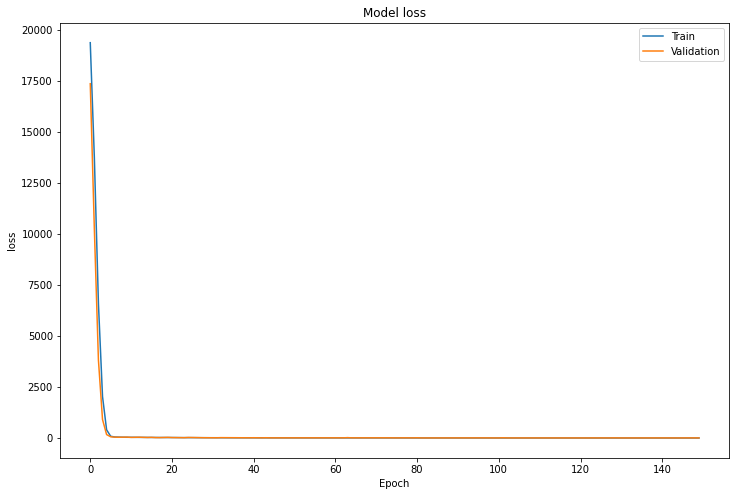

In [24]:
for i in range(len(l)//2):
    tr = metrics[i]
    val = "val_" + tr
    df_pl= df[[tr,val]]
    df_pl.rename(columns={tr:'Train',val:'Validation'},inplace=True)
    df_pl.plot(title='Model '+tr,figsize=(12,8)).set(xlabel='Epoch',ylabel=tr)


Let's try the model on a single example

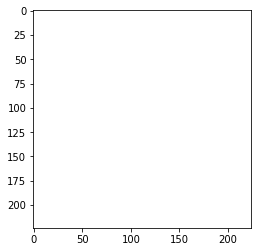

In [25]:
img = cv2.imread("/tmp/normal/Normal-1.png", 1)
img = cv2.resize(img, (224,224), interpolation=cv2.INTER_CUBIC)
img_list = []
img_list.append(np.array(img))
x = np.asarray(img_list)
recon = new_model.predict(x)
plt.imshow(recon[0])

In [26]:
diff = recon - x
np.average(diff)

32.19795